pandas-ylt
==========

Python modules for working in pandas with various loss data tables used for CAT modelling


### Read the example YLT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pandas_ylt.layer import Layer
from pandas_ylt import YearLossTable, YearEventLossTable

pd.api.extensions.register_dataframe_accessor("yel")(YearEventLossTable)
pd.api.extensions.register_dataframe_accessor("yl")(YearLossTable)

yelt = pd.read_csv("tests/_data/example_pareto_poisson_yelt.csv",
                   index_col=['Year', 'EventID', 'DayOfYear'])['Loss']
yelt.attrs['n_yrs'] = int(1e5)

display(yelt.yel.to_rp_summaries([1000, 200, 100, 10], is_ef=False).unstack(
    'Metric').style.format("{:,.0f}"))
display(yelt.yel.to_summary_stats_series().to_frame().style.format("{:,.0f}"))

Metric,AEP,OEP
ReturnPeriod,,
1000,"494,221","494,221"
200,"104,018","101,450"
100,"51,611","49,340"
10,"5,539","4,708"


,Loss
Metric,
AAL,"5,564"
STD,"158,881"


### Define an example reinsurance tower to the losses

In [2]:
layer_params = {
    "20 xs 20 (1@100)": {"limit": 20000, "xs": 20000, "agg_limit": 40000.0, "reinst_at": 1.0, "base_premium": 2000},
    "20 xs 40 (1@100)": {"limit": 20000, "xs": 40000, "agg_limit": 40000.0, "reinst_at": 1.0, "base_premium": 1000},
    "20 xs 60 (1@0)":  {"limit": 20000, "xs": 60000, "agg_limit": 40000.0, "reinst_at": 0.0, 'base_premium': 400},
    "20 xs 80 (Single Shot)": {"limit": 20000, "xs": 80000, "agg_limit": 20000.0, "reinst_at": 0.0, "base_premium": 400},
}

display(pd.DataFrame(layer_params).T
        .style.format({'limit': "{:,.0f}", 'xs': "{:,.0f}", 'agg_limit': "{:,.0f}", 'reinst_at': "{:.1%}", 'base_premium': "{:,.0f}"}))

layers = {k: Layer(**layer_params[k]) for k in layer_params.keys()}


,limit,xs,agg_limit,reinst_at,base_premium
20 xs 20 (1@100),"20,000","20,000","40,000",100.0%,"2,000"
20 xs 40 (1@100),"20,000","40,000","40,000",100.0%,"1,000"
20 xs 60 (1@0),"20,000","60,000","40,000",0.0%,400
20 xs 80 (Single Shot),"20,000","80,000","20,000",0.0%,400


### Calculate various year (event) loss tables

In [3]:
# Get a separate YLT for each layer
lyr_ylts = pd.concat({lyr: layers[lyr].ceded_ylt(yelt) for lyr in layers},
                     names=['LayerName'])

# Amount of limit reinstated in each sim year
lyr_reinst = pd.concat({lyr: layers[lyr].ceded_ylt(yelt, only_reinstated=True) for lyr in layers},
                       names=['LayerName'])

# Separate YELT for each layer
lyr_yelts = pd.concat({lyr: layers[lyr].ceded_yelt(yelt) for lyr in layers}, names=['LayerName'])

# Amount reinstated in each event
lyr_event_reinst = pd.concat({lyr: layers[lyr].ceded_yelt(yelt, only_reinstated=True) for lyr in layers}, names=['LayerName'])

# Layer premium per year
lyr_year_premiums = pd.concat(
        {lyr: pd.Series(layer_params[lyr]['base_premium'], index=pd.Index(range(1, yelt.yel.n_yrs + 1), name='Year'))
         for lyr in layers}, names=['LayerName'])

# Layer reinstatement cost per year per event
lyr_event_reinst_cost = (lyr_event_reinst
                         .divide(pd.Series({k: layers[k].notional_limit for k in layers}).rename_axis('LayerName'))
                         .multiply(pd.Series({k: layers[k].reinst_at for k in layers}).rename_axis('LayerName'))
                         .multiply(lyr_year_premiums.loc[lyr_year_premiums.index.isin(lyr_reinst.index)])
                         .rename('RiP')
                         )

# Net losses, cession to the layers
retained_yelt = yelt.subtract(lyr_yelts.groupby(yelt.index.names).sum(), fill_value=0.0)

# Net losses + reinstatement premiums
net_rip_yelt = retained_yelt.add(lyr_event_reinst_cost.groupby(yelt.index.names).sum().rename('Loss'), fill_value=0.0)

# Annual loss + reinst premiums + base premium
net_premium_ylt = net_rip_yelt.yel.to_ylt().yl.to_ylt_filled().add(lyr_year_premiums.groupby('Year').sum().rename('Loss'))



### Get the summary stats for each layer

In [4]:
# Calculate the layer stats from the YLTs
summary_stats = {k:
                     {'AAL': lyr_ylts.loc[k].yl.aal,
                      'STD': lyr_ylts.loc[k].yl.std(),
                      'AvgReinstLimit': lyr_reinst.loc[k].yl.aal,
                      'AttachRP': 1 / lyr_ylts.loc[k].yl.prob_of_a_loss,
                      'OccLimitRP': 1 / lyr_ylts.loc[k].yl.loss_exprob(layers[k].limit),
                      'OccLimitRP (Single Event)': 1 / lyr_yelts.loc[k].yel.to_ylt(is_occurrence=True).yl.loss_exprob(layers[k].limit),
                      'ExhaustRP': 1 / lyr_ylts.loc[k].yl.loss_exprob(layers[k].agg_limit),
                      'Premium+RiP': layers[k].premium + layers[k].reinst_rate * lyr_reinst.loc[k].yl.aal,
                      }
                 for k in layers}

# Display the results to check the same as before
pd.DataFrame(summary_stats).T.style.format({"AAL": "{:,.0f}",
                                            'STD': '{:,.0f}',
                                            'AvgReinstLimit': '{:.1f}',
                                            'AttachRP': "{:,.0f}",
                                            'OccLimitRP': "{:,.2f}",
                                            'OccLimitRP (Single Event)': "{:,.2f}",
                                            'ExhaustRP': "{:,.0f}",
                                            })

,AAL,STD,AvgReinstLimit,AttachRP,OccLimitRP,OccLimitRP (Single Event),ExhaustRP,Premium+RiP
20 xs 20 (1@100),336,"2,439",334.0,41,81.70,81.83,"16,667",0.000000
20 xs 40 (1@100),201,"1,934",199.9,82,120.92,120.92,"50,000",0.000000
20 xs 60 (1@0),144,"1,656",144.0,121,160.51,160.51,"100,000",0.000000
20 xs 80 (Single Shot),114,"1,481",0.0,161,195.69,196.08,196,0.000000


### Get the net and final net EP curve

In [5]:
# Calculate the OEP curves at different perspectives
return_periods = [500, 250, 200, 150, 100, 75, 50, 25, 10]
combined_rp_curves = pd.concat([
    df.yel.to_rp_summary(return_periods, is_ep=True, is_occurrence=True).rename(name)
    for name, df in
    [('Gross', yelt), ('Net', retained_yelt), ('NetRiP', net_rip_yelt)]
], axis=1)

print("OEP")
display(combined_rp_curves.reset_index().style.hide(axis=0).format("{:,.0f}"))

OEP


ReturnPeriod,Gross,Net,NetRiP
500,"272,297","192,297","195,297"
250,"123,967","43,967","46,967"
200,"101,450","21,450","24,450"
150,"75,760","20,000","23,000"
100,"49,340","20,000","22,449"
75,"36,257","20,000","21,616"
50,"24,074","20,000","20,407"
25,"12,135","12,135","12,135"
10,"4,708","4,708","4,708"


In [6]:
# Calculate the AEP curves at different perspectives
combined_rp_curves = pd.concat([
    df.yel.to_rp_summary(return_periods, is_ep=True, is_occurrence=False).rename(name)
    for name, df in
    [('Gross', yelt), ('Net', retained_yelt), ('NetRiP', net_rip_yelt)]
], axis=1)

combined_rp_curves = pd.concat([combined_rp_curves,
                                net_premium_ylt.yl.to_rp_summary(return_periods).rename('NetRIcosts')],
                               axis=1)

print("AEP")
display(combined_rp_curves.reset_index().style.hide(axis=0).format("{:,.0f}"))

AEP


ReturnPeriod,Gross,Net,NetRiP,NetRIcosts
500,"276,674","196,411","199,411","203,211"
250,"127,284","46,064","49,064","52,864"
200,"104,018","34,505","36,555","40,355"
150,"77,810","26,096","27,493","31,293"
100,"51,611","22,352","23,954","27,754"
75,"38,447","21,164","23,000","26,800"
50,"25,875","20,000","21,262","25,062"
25,"13,450","13,450","13,450","17,250"
10,"5,539","5,539","5,539","9,339"


#### Plot the OEP

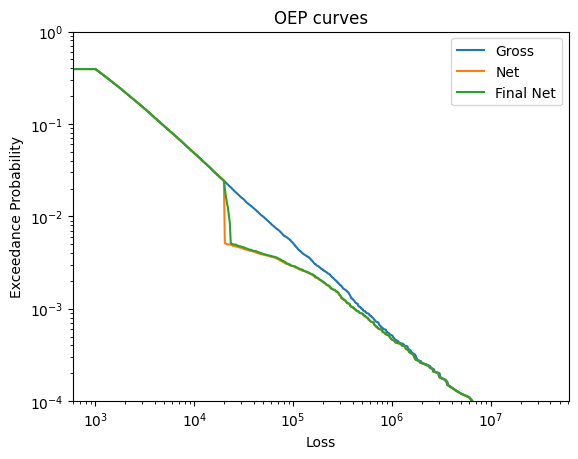

In [7]:
# Make a plot
fig, ax = plt.subplots(1)

for name, df in [('Gross', yelt), ('Net', retained_yelt), ('Final Net', net_rip_yelt)]:
    df.yel.to_ylt(is_occurrence=True).yl.to_ep_curve().plot('Loss', 'ExProb', ax=ax,
                                                            label=name)

ax.set(xscale='log', yscale='log', ylim=[1e-4, 1], ylabel='Exceedance Probability')
plt.title('OEP curves')
plt.show()

Plot AEP

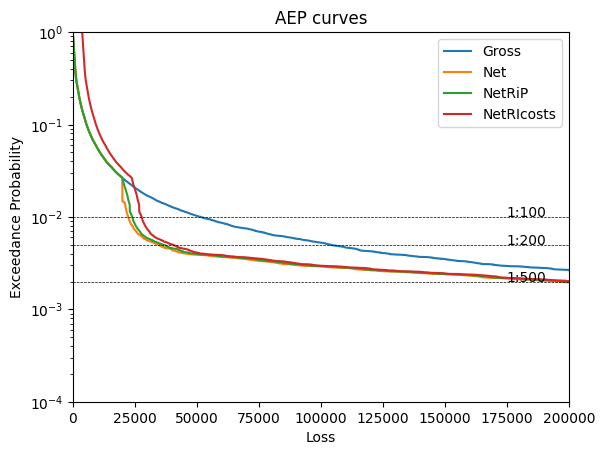

In [8]:
# Make a plot
fig, ax = plt.subplots(1)

for name, df in [('Gross', yelt), ('Net', retained_yelt), ('NetRiP', net_rip_yelt)]:
    df.yel.to_ylt().yl.to_ep_curve().plot('Loss', 'ExProb', ax=ax, label=name)

for name, df in [('NetRIcosts', net_premium_ylt)]:
    df.yl.to_ep_curve().plot('Loss', 'ExProb', ax=ax, label=name)

for rp in [100, 200, 500]:
    ax.plot(ax.get_xlim(), [1 / rp, 1 / rp], '--k', linewidth=0.5)
    ax.text(1.75e5, 1 / rp, f"1:{rp}")

ax.set(yscale='log', ylim=[1e-4, 1], xlim=[0, 0.2e6], ylabel='Exceedance Probability')
plt.title('AEP curves')
plt.show()

### Simplified example numbers to show the impact on the cost of capital

In [9]:
benchmark_exprob = 1 / 200.0
capital_ratio = 2.0
capital_cost_rate = 0.08
cost_of_reins = sum([x.premium for x in layers.values()])

# Base case with no reinsurance
print("No reinsurance.")

capital_required = capital_ratio * yelt.yel.to_ylt().yl.loss_at_exprobs(
    benchmark_exprob)
capital_buffer = capital_required * (capital_ratio - 1) / capital_ratio
print(f"\tCapital Requirement: {capital_required:,.0f} for a buffer of " +
      f"{capital_buffer:,.0f} at the 1:{1 / benchmark_exprob:,.0f}")

capital_costs = capital_required * capital_cost_rate
print(f"\tCosts associated with holding the capital {capital_costs:,.0f}")

peak_loss = capital_required
print("\tReturn period for peak loss = " +
      f"{1 / yelt.yel.to_ylt().yl.loss_exprobs([peak_loss])[0]:,.0f}")

# How reinsuance changes the numbers
print("Reinsurance + same capital.")

capital_used = net_rip_yelt.yel.to_ylt().yl.loss_at_exprobs(benchmark_exprob)
print(f"\tNow have buffer of {capital_required - capital_used - cost_of_reins:,.0f}")

print("\tReturn period for peak loss = " +
      f"{1 / net_rip_yelt.yel.to_ylt().yl.loss_exprobs(peak_loss - cost_of_reins):,.0f}")

print(f"\tCost of reins = {cost_of_reins:,.0f}")
print(f"\tCost of reins + maintinaing capital = {cost_of_reins + capital_costs:,.0f}")

# If reinsurance is used instead of capital
print("Reinsurance offsetting capital.")

new_capital_requirement = capital_buffer + capital_used
print(f"\tNew Capital Requirement: {new_capital_requirement:,.0f} for a buffer of " +
      f"{capital_buffer:,.0f}")

print("\tReturn period for peak loss = " +
      f"{1 / net_rip_yelt.yel.to_ylt().yl.loss_exprobs([new_capital_requirement])[0]:,.0f}")

new_peak_loss = net_rip_yelt.yel.to_ylt().yl.loss_at_exprobs(
    benchmark_exprob) + capital_buffer

new_capital_costs = new_capital_requirement * capital_cost_rate
print(
    f"\tCost of reins + maintinaing capital = {cost_of_reins + new_capital_costs:,.0f}")



No reinsurance.
	Capital Requirement: 208,036 for a buffer of 104,018 at the 1:200
	Costs associated with holding the capital 16,643
	Return period for peak loss = 388
Reinsurance + same capital.
	Now have buffer of 171,481
	Return period for peak loss = 524
	Cost of reins = 0
	Cost of reins + maintinaing capital = 16,643
Reinsurance offsetting capital.
	New Capital Requirement: 140,572 for a buffer of 104,018
	Return period for peak loss = 405
	Cost of reins + maintinaing capital = 11,246


### Define some layers

In [10]:



# layers = [
#     # First loss
#     {'name': '20 xs 0', 'layer': Layer(**{'limit': 20000, 'xs': 0, 'agg_limit': 20000.0})},    
#     {'name': '20 xs 20', 'layer': Layer(**{'limit': 20000, 'xs': 20000, 'agg_limit': 20000.0})},
#     {'name': '20 xs 40', 'layer': Layer(**{'limit': 20000, 'xs': 40000, 'agg_limit': 20000.0})},
#     {'name': '20 xs 60', 'layer': Layer(**{'limit': 20000, 'xs': 60000, 'agg_limit': 20000.0})},    
#     {'name': '20 xs 80', 'layer': Layer(**{'limit': 20000, 'xs': 80000, 'agg_limit': 20000.0})},    
#     # Second loss
#     {'name': '20 xs 0 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 0, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},        
#     {'name': '20 xs 20 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 20000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},
#     {'name': '20 xs 40 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 40000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},
#     {'name': '20 xs 60 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 60000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})}, 
#     {'name': '20 xs 80 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 80000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})}, 
# ]

